In [2]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
log = pm4py.read_xes("Road_Traffic_Fine_Management_Process.xes")

parsing log, completed traces :: 100%|██████████| 150370/150370 [00:20<00:00, 7238.41it/s]


In [73]:
df = pm4py.convert_to_dataframe(log)
df.head()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN


### Features to extract:
- total fine amount (fine + penalty)
- sum of expenses (total_expenses)
- total amount the offender is obliged to pay (fine + penalty + expense)
- total amount the offender actually pays (max(totalAmountPayment))
- payment completed (boolean)
- number of penalties (nr of non null values in amount column per case - 1)
- number of payment installments (nr of non null values in paymentAmount column per case)
- initial fine amount (min(amount))
- total penalty amount (max(amount) - min(amount))

Example that illustrates how the features are calculated:

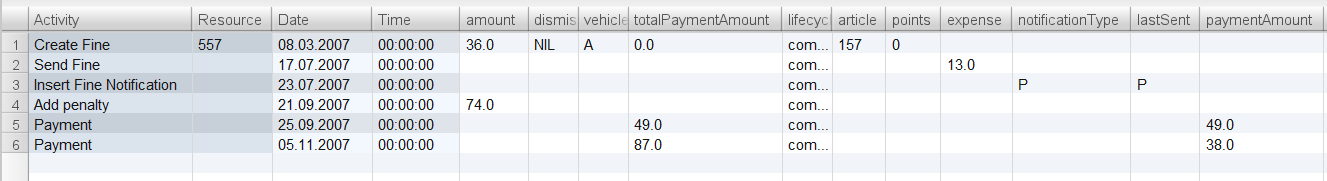

The penalty is 74 - 36 = 38

The expense is 13, meaning the total amount needed to be paid is 74 + 13 = 87

The total amount the offender actually pays is 87 (in two installments of 49 and 38)

The payment is completed.

The number of penalties is 1.


In [74]:
# group by case:concept:name and calculate the above features one by one
grouped = df.groupby('case:concept:name')


In [75]:

# the max of the amount will be the fine_amount, because the amount is increased in case there is a fine
# since there are multiple rows in the df with the same case:concept:name, we add this fine_amount to each row in the df
df['total_fine_amount'] = df['case:concept:name'].map(grouped['amount'].max())
df.head()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola,total_fine_amount
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN,35.0
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN,35.0
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN,71.5
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN,71.5
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN,71.5


Validating that there are not more than one expense per case

In [76]:
# aggregate expenses to a list
grouped_expenses = grouped['expense'].apply(list)

# remove nan from the lists
grouped_expenses = grouped_expenses.apply(lambda x: [i for i in x if pd.notna(i)])
grouped_expenses.head(20)

# return cases where the list has more than 1 element
grouped_expenses[grouped_expenses.apply(lambda x: len(x) > 1)]


Series([], Name: expense, dtype: object)

In [77]:
expenses_sum = grouped_expenses.apply(lambda x: sum(x))
expenses_sum.head()

df['total_expenses'] = df['case:concept:name'].map(expenses_sum)
df.head()


,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola,total_fine_amount,total_expenses
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN,35.0,11.0
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN,35.0,11.0
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN,71.5,11.0
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN,71.5,11.0
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN,71.5,11.0


In [78]:
# total_payment_obligation = total_fine_amount + total_expenses
df['total_payment_obligation'] = df['total_fine_amount'] + df['total_expenses']
df.head()


,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola,total_fine_amount,total_expenses,total_payment_obligation
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN,35.0,11.0,46.0
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN,35.0,11.0,46.0
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN,71.5,11.0,82.5
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN,71.5,11.0,82.5
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN,71.5,11.0,82.5


In [79]:
df['total_payment_completed'] = df['case:concept:name'].map(grouped['totalPaymentAmount'].max())
df.head()


,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola,total_fine_amount,total_expenses,total_payment_obligation,total_payment_completed
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN,35.0,11.0,46.0,0.0
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN,35.0,11.0,46.0,0.0
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN,71.5,11.0,82.5,0.0
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN,71.5,11.0,82.5,0.0
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN,71.5,11.0,82.5,0.0


In [80]:
# count the number of cases where the total_payment_obligation is less or equal to the total_payment_completed, grouped by case:concept:name
print(df[df['total_payment_obligation'] <= df['total_payment_completed']].groupby('case:concept:name').size())

# count the number of cases where the total_payment_obligation is greater than the total_payment_completed, grouped by case:concept:name
print(df[df['total_payment_obligation'] > df['total_payment_completed']].groupby('case:concept:name').size())


case:concept:name
A10000    5
A10005    2
A10007    2
A10009    6
A10022    2
         ..
V9930     3
V9936     3
V9938     3
V9964     5
V9996     3
Length: 60247, dtype: int64
case:concept:name
A1        2
A100      5
A10001    6
A10004    5
A10008    5
         ..
V9992     5
V9995     5
V9997     5
V9998     5
V9999     5
Length: 90123, dtype: int64


In [81]:
# save this as a boolean column named 'payment_completed'
df['payment_completed'] = df['total_payment_obligation'] <= df['total_payment_completed']
df.head()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,...,expense,notificationType,lastSent,paymentAmount,matricola,total_fine_amount,total_expenses,total_payment_obligation,total_payment_completed,payment_completed
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,...,NaN,NaN,NaN,NaN,NaN,35.0,11.0,46.0,0.0,False
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,...,11.0,NaN,NaN,NaN,NaN,35.0,11.0,46.0,0.0,False
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,...,NaN,NaN,NaN,NaN,NaN,71.5,11.0,82.5,0.0,False
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,...,11.0,NaN,NaN,NaN,NaN,71.5,11.0,82.5,0.0,False
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,...,NaN,P,P,NaN,NaN,71.5,11.0,82.5,0.0,False


In [82]:
# number of penalties (nr of non null values in amount column per case - 1)
df['number_of_penalties'] = df['case:concept:name'].map(grouped['amount'].count() - 1)

# show the distribution of the number of penalties
df.groupby('case:concept:name')['number_of_penalties'].max().value_counts()


number_of_penalties
1    79860
0    70510
Name: count, dtype: int64

Consistent with findings in apromore.

In [83]:
# number of payment installments (nr of non null values in paymentAmount column per case)
df['number_of_payment_installments'] = df['case:concept:name'].map(grouped['paymentAmount'].count())

# show the distribution of the number of payment installments
df.groupby('case:concept:name')['number_of_payment_installments'].max().value_counts()


number_of_payment_installments
0     80655
1     62173
2      7366
3       123
4        19
6        10
5         7
10        6
7         6
8         2
12        1
15        1
11        1
Name: count, dtype: int64

In [84]:
# initial fine amount (min(amount))
df['initial_fine_amount'] = df['case:concept:name'].map(grouped['amount'].min())

# total penalty amount (max(amount) - min(amount))
df['total_penalty_amount'] = df['case:concept:name'].map(grouped['amount'].max() - grouped['amount'].min())

df.head()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,...,matricola,total_fine_amount,total_expenses,total_payment_obligation,total_payment_completed,payment_completed,number_of_penalties,number_of_payment_installments,initial_fine_amount,total_penalty_amount
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,...,NaN,35.0,11.0,46.0,0.0,False,0,0,35.0,0.0
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,...,NaN,35.0,11.0,46.0,0.0,False,0,0,35.0,0.0
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,...,NaN,71.5,11.0,82.5,0.0,False,1,0,35.0,36.5
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,...,NaN,71.5,11.0,82.5,0.0,False,1,0,35.0,36.5
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,...,NaN,71.5,11.0,82.5,0.0,False,1,0,35.0,36.5


In [90]:
# create a df with the new features, grouped by case:concept:name
df_features = df.groupby('case:concept:name').agg({
    'total_fine_amount': 'max',
    'total_expenses': 'max',
    'total_payment_obligation': 'max',
    'total_payment_completed': 'max',
    'payment_completed': 'max',
    'number_of_penalties': 'max',
    'number_of_payment_installments': 'max',
    'initial_fine_amount': 'min',
    'total_penalty_amount': 'max',
})
df_features.head()

,total_fine_amount,total_expenses,total_payment_obligation,total_payment_completed,payment_completed,number_of_penalties,number_of_payment_installments,initial_fine_amount,total_penalty_amount
case:concept:name,,,,,,,,,
A1,35.0,11.0,46.0,0.0,False,0,0,35.0,0.0
A100,71.5,11.0,82.5,0.0,False,1,0,35.0,36.5
A10000,74.0,13.0,87.0,87.0,True,1,1,36.0,38.0
A10001,74.0,13.0,87.0,0.0,False,1,0,36.0,38.0
A10004,74.0,13.0,87.0,0.0,False,1,0,36.0,38.0


In [91]:
df_features.describe()

,total_fine_amount,total_expenses,total_payment_obligation,total_payment_completed,number_of_penalties,number_of_payment_installments,initial_fine_amount,total_penalty_amount
count,150370.000000,150370.000000,150370.000000,150370.000000,150370.000000,150370.000000,150370.000000,150370.000000
mean,71.416780,8.263211,79.679991,23.965960,0.531090,0.516067,44.715380,26.701401
std,100.537082,6.453667,101.574594,40.245096,0.499034,0.605049,49.416618,56.024787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,0.000000,38.000000,0.000000,0.000000,0.000000,32.800000,0.000000
50%,62.590000,11.000000,69.050000,0.000000,1.000000,0.000000,35.000000,22.000000
75%,71.500000,13.500000,85.750000,36.000000,1.000000,1.000000,38.000000,36.500000
max,8000.000000,76.000000,8019.850000,4021.000000,1.000000,15.000000,4351.000000,5660.000000


In [89]:
df_features['payment_completed'].value_counts()


payment_completed
False    90123
True     60247
Name: count, dtype: int64

In [92]:
# save to csv
df.to_csv("road_traffic_fine_management_process_extracted.csv", index=False)

In [3]:
# load df
df = pd.read_csv("road_traffic_fine_management_process_extracted.csv")
df.head()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,...,matricola,total_fine_amount,total_expenses,total_payment_obligation,total_payment_completed,payment_completed,number_of_penalties,number_of_payment_installments,initial_fine_amount,total_penalty_amount
0,35.0,561.0,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,...,NaN,35.0,11.0,46.0,0.0,False,0,0,35.0,0.0
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,...,NaN,35.0,11.0,46.0,0.0,False,0,0,35.0,0.0
2,35.0,561.0,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,...,NaN,71.5,11.0,82.5,0.0,False,1,0,35.0,36.5
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,...,NaN,71.5,11.0,82.5,0.0,False,1,0,35.0,36.5
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,...,NaN,71.5,11.0,82.5,0.0,False,1,0,35.0,36.5


In [5]:
# show rows, where concept:name is 'Send for Credit Collection' and payment_completed is True
df[(df['concept:name'] == 'Send for Credit Collection') & (df['payment_completed'] == True)]
# show the columns for these rows: case:concept:name, total_payment_obligation, total_payment_completed, payment_completed
df[(df['concept:name'] == 'Send for Credit Collection') & (df['payment_completed'] == True)][['case:concept:name', 'total_payment_obligation', 'total_payment_completed', 'payment_completed']]


,case:concept:name,total_payment_obligation,total_payment_completed,payment_completed
83379,C12749,0.00,0.00,True
146358,N35881,79.03,79.30,True
474827,S66168,144.63,144.63,True
